# CS 375 - Tutorial 3 (Retinal Models and Neural Coding)

The retina comprises the first component of visual processing, and even at this level, the retina must compress visual information from 100 million photoreceptors down to 1 million ganglion (output) cells. In just a few layers, the retina predicts object motion [1], predicts complex spatiotemporal patterns [2], and can reduce spatiotemporal redudancy in natural scenes [3].

We will be analyzing data recorded in the Baccus Lab from a salamander retinal ganglion cell (RGC) in response to a white noise stimulus. We will use a simple encoding model known as a Linear-Nonlinear (LN) model [4] that predicts the RGC response to the stimulus, and we will use spike-triggered analysis [5] to compute its linear receptive field. This will then motivate the use of deeper encoding models featured in [6], which you will explore in your upcoming homework assignment.

## 0.) Loading data and experiment details

The data we will be using is in rgc_data.npz. It consists of a 16.67 minute recording of a ganglion cell from the salamander retina. The stimulus was flickering white noise bars, sampled at a frame rate of 100 Hz. The stimulus array has dimensions (30x100000) corresponding to the pixel values of the 30 bars over 100000 frames. The time array contains the time (in seconds) of the stimulus presentation for each stimulus frame. The spike_times array contains the spike times of an isolated retinal ganglion cell (RGC) recorded in response to the stimulus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [3]:
rgc_data = np.load('rgc_data.npz', encoding='latin1')['arr_0'][()]
stimulus = rgc_data['stimulus']
time = rgc_data['time']
spike_times = rgc_data['spike_times']

In [4]:
stimulus.shape

(30, 100000)

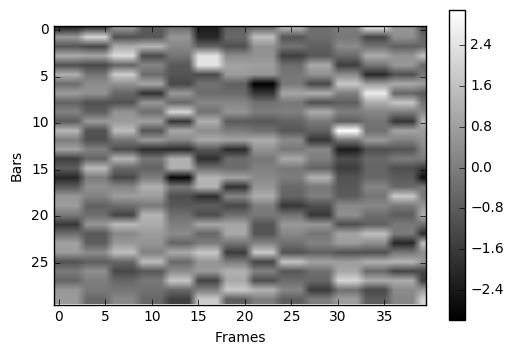

In [5]:
plt.imshow(stimulus[:, :40], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.xlabel('Frames')
plt.ylabel('Bars')

# 1.) Spike-triggered analysis

# To start our analysis, we begin by computing the linear component of the LN model. In order to do this, we compute the spike-triggered ensemble (STE). This contains the stimulus that directly preceded a particular spike, for every spike.

# First, we initialize the STE.

In [6]:
dt = 0.01 # stimulus sampling rate (in seconds)
spatial_dim = stimulus.shape[0]        # the number of spatial dimensions in the stimulus (number of bars)
filter_length = 40                     # the number of temporal dimensions in the stimulus (integration time of rgc is 400 ms, so 40 frames)

In [7]:
# cut out the first few spikes that occur before the length of the filter (in seconds) has elapsed
spike_times = spike_times[spike_times > filter_length * dt]

In [8]:
# store the indices of the time array corresponding to each spike
# (you'll use this when computing histograms and the nonlinearity of the LN model)
spike_indices = np.zeros(spike_times.shape)
num_spike_times = spike_times.shape[0]

In [9]:
# initialize an array that will store the spike-triggered ensemble (STE)
# it is a matrix with dimensions given by: the number of spikes and the total of dimensions in the filter
ste = np.zeros((num_spike_times, spatial_dim*filter_length))

# Now, compute the STE (fill in the code below)

In [10]:
for t in range(num_spike_times):
    # get the nearest index of this spike time
    spike_idx = np.sum(time < spike_times[t]) # timestep that is closest to given spike time
    spike_indices[t] = spike_idx
    # select out the stimulus preceeding the spike, and store it in the ste array
    # FILL IN HERE
    prev_stim = stimulus[:, spike_idx-filter_length:spike_idx]
    ste[t, :] = prev_stim.flatten() # flatten it

# Compute the STA (average response preceding the stimulus)

In [11]:
# FILL IN HERE
sta = np.mean(ste, axis=0)

# unit norm the sta (since the scale is arbitrary)
sta = sta / np.linalg.norm(sta)

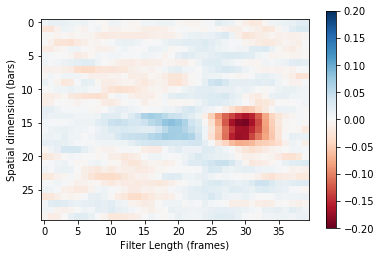

In [12]:
sta_plot = sta.reshape(spatial_dim, filter_length) # reshape to 30 by 40
plt.imshow(sta_plot, cmap='RdBu')
plt.xlabel('Filter Length (frames)')
plt.ylabel('Spatial dimension (bars)')
plt.colorbar()
plt.clim(-0.2,0.2)

# Biological Interpretation (Center-Surround Receptive Fields)

## What does the above plot tell us about this ganglion cell's response?

For most positions on the surface of the retina, flashing a spot of light has no effect on the RGC's response. However, within a particular region, known as the receptive field, flashing the light affects the ganglion cell's response. The receptive field is therefore the region of the visual field in which light stimuli evoke responses in the ganglion cell.

In the dark, a photoreceptor (rod/cone) cell will release glutamate, which inhibits the ON bipolar cells and excites the OFF bipolar cells. In the light, ON bipolar cells become are excited, while the OFF bipolar cells become inhibited. This stratification of the bipolar cell population contributes the receptive field of the ganglion cell (since bipolar cells synapse onto ganglion cells).

Due to these two populations of bipolar cells, the receptive field of the retinal ganglion cell is subdivided into two regions: a center and a surround. There are two types of receptive fields:
1. ON center/OFF surround cell: Flashing small bright spot in the center subregion increases the cell's response. Flashing a bright annulus in the surround subregion inhibits the cell's response. There is little or no response to a large (full field) spot of light that covers both the center and the surround because excitation in the center cancels the inhibition from the surround, called lateral inhibition.
2. An OFF-center/ON-surround ganglion cell has the opposite arrangement. It gets inhibition from a small spot of light in the center, and excitation from an annulus in the surround.

Photo credit: http://www.cns.nyu.edu/~david/courses/perception/lecturenotes/ganglion/ganglion.html

<img src="files/receptive_field.png">

<img src="files/linear_receptive_field.png">

## So, is this RGC an ON-center or an OFF-center ganglion cell? (Answer: OFF-center)

# 2.) Adding the nonlinearity

## RGCs have thresholds (nonlinearities) that go from membrane potentials ($u(t)$) to predicted firing rates ($\hat{r}(t)$). Therefore, we need to account for the amount of amplification necessary to predict the ganglion cell response given the stimulus response and the STA (the linear weights).


$$u(t) = sta*x(t) = sta\cdot x(t-filterlength:t)$$

$$\hat{r}(t) = f(u(t))$$

## Looping over time, compute the linear projection of each stimulus slice onto the STA and store it in the variable u

In [13]:
u = np.zeros(time.shape[0])      # the variable `u` will store the projection at each time step (predicted membrane potentials)
for t in range(filter_length, time.shape[0]): # loop over each time point
    # FILL IN HERE
# extract the stimulus slice at this time point
    stimulus_slice = stimulus[:, t-filter_length:t]
    stimulus_slice = stimulus_slice.flatten()
# store the linear projection (dot product) of the stimulus slice onto the STA in u
    u[t] = np.dot(stimulus_slice, sta)

## Compute the nonlinearity as a ratio of histograms

In [14]:
spike_indices = spike_indices.astype('int64')
# bin the spike times according to the time array
spike_counts, _ = np.histogram(spike_times, time)

In [15]:
bins = np.linspace(-6, 6, 50) # min and max of u
raw, _ = np.histogram(u, bins) # discretize u into 50 bins
raw = raw / float(np.sum(raw))    # p(stimulus)
conditional, _ = np.histogram(u[spike_indices], bins)
conditional = conditional / np.sum(conditional)  # p(stimulus|spike)
nln = (np.mean(spike_counts) * conditional) / raw # p(spike|stimulus)

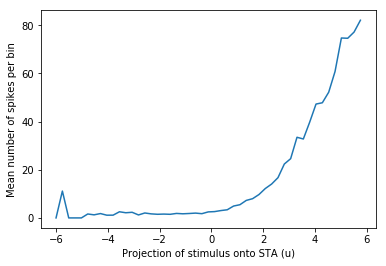

In [16]:
plt.plot(bins[:-1], nln / dt)
plt.xlabel('Projection of stimulus onto STA (u)')
plt.ylabel('Mean number of spikes per bin')

# 3.) Limitations of the LN model - Next Steps

There are many cell types in the retina, and the LN model ignores cell types as it consists of a single linear filter. Moreover, the the retina is multilayered (photoreceptor/bipolar layer, amacrine cell layer, ganglion cell layer), so it is not clear that we have adequately modeled this. In fact, LN models are poor predictors of the retina's response to natural scenes.

The stimulus is now fully spatiotemporal is a movie where each image is 50 x 50 consisting of 40 frames each (note that the 40 frames corresponds to the temporal integration time of the RGC). The CNN architecture you will be training consists of 8 13x13 filters in the first convolutional layer (note: much larger than your traditional deep CNN with 7x7 or 3x3 filters), 2x2 maxpooling, 16 dense units, and a final dense layer (followed by a softplus nonlinearity). The loss function is the Poisson negative log likelihood, which the model is minimizing. Performance saturated after 3 layers. Thus, this network incorporates multiple "cell types" and is a multilayered architecture. But what exactly does this buy us over the LN model?
 

<img src="files/Slide09.png">

Photo credit: [6], Figure 2A

<img src="files/reliabilities.png">

Photo credit: [6], Figure 4. Here we see the CNN generalizes better when trained on less data, and generalizes across stimuli, indicating that it is a superior model class compared to the LN model.

<img src="files/generalization.png">

Photo credit: [6], Figure 7. If we turn this architecture into an RNN (that has gating mechanisms) at the hidden layer, we can capture adaptation over long timescales (without explicitly training on such data, only through training on natural scenes).

<img src="files/rnn.png">

# Acknowledgements

This tutorial was adapted from an assigment in NEPR 208 (Neurosciences Computational Core Module), taught in Spring 2016 by Stephen A Baccus and Niru Maheswaranathan. The data used in this tutorial is from the Baccus Lab at Stanford.

# References

1. Stephen A Baccus, Bence P Olveczky, Mihai Manu, and Markus Meister. A retinal circuit that computes object motion.  The Journal of Neuroscience, 28(27):6807–6817, 2008.

2. Toshihiko Hosoya, Stephen A Baccus, and Markus Meister. Dynamic predictive coding by the retina. Nature, 436(7047):71–77, 2005.

3. Mandyam V Srinivasan, Simon B Laughlin, and Andreas Dubs. Predictive coding: a fresh view of inhibition in the retina. Proceedings of the Royal Society of London. Series B. Biological Sciences, 216(1205):427–459, 1982.

4. EJ Chichilnisky. A simple white noise analysis of neuronal light responses. Network: Computation in Neural Systems, 12(2):199-213, 2001.

5. Odelia Schwartz, Jonathan W Pillow, Nicole C Rust, and Eero P Simoncelli. Spike-triggered neural characterization. Journal of Vision, 6(4):484-507, 2006.

6. Lane T McIntosh, Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. Deep learning models of the retinal response to natural scenes. In Advances in Neural Information Processing Systems (NIPS 2016), pp. 1369-1377, 2016.